Reference Code: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [2]:
import gymnasium as gym
import glob
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
headers = ['race_id', 'circuit_id', 'year', 'round', 'race_length', 'driver_id', 'lap', 'position', 'milliseconds', 'pit_stop_count', 'pit_stop_milliseconds', 'pit_stop', 'rating', 'fcy', 'battle', 'next_lap_time', 'fitted_tire', 'tire_age', 'starting_position', 'gap_from_the_car_in_front', 'gap_from_the_following_car', 'lap_time_of_the_car_in_front', 'lap_time_of_the_following_car', 'drs']

In [4]:
TYRE_MAP = {'HYPERSOFT': 1, 'ULTRASOFT': 1, 'SUPERSOFT': 1, 'SOFT': 1, 'MEDIUM': 2, 'HARD': 3, 'INTERMEDIATE': 4, 'WET': 5, 'nan': 0}
NUM_TYRES = 5
ROUND_MAP = {'british': 1, 'austrian': 2, 'brazilian': 3}

In [5]:
gp = 'british'
files = glob.glob(f'data/new/*_{gp}_data.csv')
files.sort()

# Load data
dataFrame = pd.concat([pd.read_csv(f, names=headers) for f in files], ignore_index=True)
dataFrame.shape

(3687, 24)

In [6]:
dataFrame['fitted_tire'] = dataFrame['fitted_tire'].map(TYRE_MAP)
dataFrame['round'] = dataFrame['round'].map(ROUND_MAP)
dataFrame = dataFrame.drop(columns=['race_id', 'circuit_id', 'year'])
dataFrame = dataFrame.dropna()
dataFrame.head()

,round,race_length,driver_id,lap,position,milliseconds,pit_stop_count,pit_stop_milliseconds,pit_stop,rating,...,battle,next_lap_time,fitted_tire,tire_age,starting_position,gap_from_the_car_in_front,gap_from_the_following_car,lap_time_of_the_car_in_front,lap_time_of_the_following_car,drs
3,1.0,52,5,3.0,1.0,92918.0,2,0.0,0,25.0,...,0,92723.0,1.0,4.0,1.0,0.0,4007.0,0.0,93267.0,0
4,1.0,52,5,4.0,1.0,92723.0,2,0.0,0,25.0,...,0,93108.0,1.0,5.0,1.0,0.0,4515.0,0.0,93616.0,0
5,1.0,52,5,5.0,1.0,93108.0,2,0.0,0,25.0,...,0,92991.0,1.0,6.0,1.0,0.0,5177.0,0.0,93653.0,0
6,1.0,52,5,6.0,1.0,92991.0,2,0.0,0,25.0,...,0,93359.0,1.0,7.0,1.0,0.0,5312.0,0.0,93494.0,0
7,1.0,52,5,7.0,1.0,93359.0,2,0.0,0,25.0,...,0,93315.0,1.0,8.0,1.0,0.0,5700.0,0.0,93703.0,0


In [7]:
dataFrame['milliseconds'] = dataFrame['milliseconds'].astype(float)
dataFrame['next_lap_time'] = dataFrame['next_lap_time'].astype(float)
dataFrame['lap_time_of_the_car_in_front'] = dataFrame['lap_time_of_the_car_in_front'].astype(float)
dataFrame['lap_time_of_the_following_car'] = dataFrame['lap_time_of_the_following_car'].astype(float)
dataFrame['gap_from_the_car_in_front'] = dataFrame['gap_from_the_car_in_front'].astype(float)
dataFrame['gap_from_the_following_car'] = dataFrame['gap_from_the_following_car'].astype(float)
dataFrame['lap'] = dataFrame['lap'].astype(float).astype(int)
dataFrame['position'] = dataFrame['position'].astype(float).astype(int)
dataFrame['pit_stop_count'] = dataFrame['pit_stop_count'].astype(int)
dataFrame['pit_stop_milliseconds'] = dataFrame['pit_stop_milliseconds'].astype(float)
dataFrame['pit_stop'] = dataFrame['pit_stop'].astype(int)

In [8]:
dataFrame['milliseconds'] = dataFrame['milliseconds'] / 1000
dataFrame['next_lap_time'] = dataFrame['next_lap_time'] / 1000
dataFrame['pit_stop_milliseconds'] = dataFrame['pit_stop_milliseconds'] / 1000
dataFrame['gap_from_the_car_in_front'] = dataFrame['gap_from_the_car_in_front'] / 1000
dataFrame['gap_from_the_following_car'] = dataFrame['gap_from_the_following_car'] / 1000
dataFrame['lap_time_of_the_car_in_front'] = dataFrame['lap_time_of_the_car_in_front'] / 1000
dataFrame['lap_time_of_the_following_car'] = dataFrame['lap_time_of_the_following_car'] / 1000

In [9]:
class FormulaOneRacingEnv(gym.Env):
    """
    A Markov Decision Process model for Formula 1 race strategy, incorporating detailed race data.
    """

    def __init__(self, df):
        super(FormulaOneRacingEnv, self).__init__()

        self.df = df
        self.current_index = 1

        self.lap_count = int(self.df['race_length'].max())  # Total laps

        # Action 0: No pit stop
        # Action 1-5: Pit stop and change to soft, medium, hard, intermediates, wets
        self.num_tire_types = NUM_TYRES
        self.action_space = gym.spaces.Tuple((gym.spaces.Discrete(self.lap_count),  # Lap number to take action
                                          gym.spaces.Discrete(self.num_tire_types + 1)))  # Tire type including no action
        
        self.optimal_lap_time = self.df['milliseconds'].mean()  # Assume the fastest lap time is the optimal lap time
        self.optimal_pit_stop_time = self.df['pit_stop_milliseconds'].mean()  # Assume the average pit stop time is the optimal pit stop time

        # Define the state space
        self.observation_space = gym.spaces.Dict({
            'driver_id': gym.spaces.Discrete(len(self.df['driver_id'].unique())),
            'lap': gym.spaces.Discrete(self.lap_count),
            'position': gym.spaces.Discrete(20),
            'milliseconds': gym.spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),
            'pit_stop_count': gym.spaces.Discrete(10),
            'pit_stop_milliseconds': gym.spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),
            'pit_stop': gym.spaces.Discrete(2),
            'fcy': gym.spaces.Discrete(2),
            'battle': gym.spaces.Discrete(2),
            'next_lap_time': gym.spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),
            'fitted_tire': gym.spaces.Discrete(self.num_tire_types),
            'tire_age': gym.spaces.Discrete(100),
            'starting_position': gym.spaces.Discrete(20),
            'gap_from_the_car_in_front': gym.spaces.Box(low=-float('inf'), high=float('inf'), shape=(1,), dtype=np.float32),
            'gap_from_the_following_car': gym.spaces.Box(low=-float('inf'), high=float('inf'), shape=(1,), dtype=np.float32),
            'lap_time_of_the_car_in_front': gym.spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),
            'lap_time_of_the_following_car': gym.spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),
            'drs': gym.spaces.Discrete(2)
        })

    def set_state_from_data(self):
        row = self.df.iloc[self.current_index]
        self.state = {
            'driver_id': row['driver_id'],
            'lap': row['lap'],
            'position': row['position'],
            'milliseconds': float(row['milliseconds']),
            'pit_stop_count': int(row['pit_stop_count']),
            'pit_stop_milliseconds': row['pit_stop_milliseconds'],
            'pit_stop': row['pit_stop'],
            'fcy': row['fcy'],
            'battle': row['battle'],
            'next_lap_time': row['next_lap_time'],
            'fitted_tire': row['fitted_tire'],
            'tire_age': int(float(row['tire_age'])),
            'starting_position': row['starting_position'],
            'gap_from_the_car_in_front': row['gap_from_the_car_in_front'],
            'gap_from_the_following_car': row['gap_from_the_following_car'],
            'lap_time_of_the_car_in_front': row['lap_time_of_the_car_in_front'],
            'lap_time_of_the_following_car': row['lap_time_of_the_following_car'],
            'drs': row['drs']
        }
        self.current_index += 1

    def step(self, action):
        reward = self.reward_system(action)

        self.current_index += 1
        if self.current_index >= len(self.df):
            done = True
        else:
            self.set_state_from_data()
            done = False
        
        return self.state, reward, done, {}

    def reset(self):
        self.current_index = 1
        self.set_state_from_data()
        return self.state

    def render(self, mode='human'):
        pass

    def reward_system(self, action):
        lap_decision, tire_choice = action
        reward = 0

        # Check if the action corresponds to making a pit stop on the current lap
        if self.state['lap'] == lap_decision and tire_choice != 0 and tire_choice != self.state['fitted_tire'] and self.state['tire_age'] > 15:
            # Update state to reflect the pit stop
            self.state['pit_stop_count'] += 1
            self.state['tire_age'] = 0  # Reset tire age

            # Calculate penalty based on the tire choice and other pit stop dynamics
            reward -= self.calculate_pit_stop_time_penalty(tire_choice)
        else:
            # Calculate the reward based on lap time if no pit stop is made
            self.state['tire_age'] += 1  # Increment tire age
            reward += self.calculate_lap_time_reward()

        return reward

    def calculate_pit_stop_time_penalty(self, tire_choice):
        if tire_choice == self.state['fitted_tire'] and not self.state['pit_stop']:
            return 0
        tire_penalty = {
            1: 10,  # Soft tires
            2: 20,  # Medium tires
            3: 30,  # Hard tires
            4: 50,  # Intermediates
            5: 80   # Wets
        }
        if self.optimal_pit_stop_time > self.state['pit_stop_milliseconds']:
            time_penalty = self.state['pit_stop_milliseconds'] + tire_penalty.get(tire_choice, 0) * 0.5
        else:
            time_penalty = self.state['pit_stop_milliseconds'] + tire_penalty.get(tire_choice, 0)
        return time_penalty / 1000  # Scale the penalty
    
    def calculate_lap_time_reward(self):
        current_lap_time = self.state['milliseconds']

        time_difference = self.optimal_lap_time - current_lap_time
        reward = time_difference / 1000  # Scale the reward
        return reward

In [10]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, num_laps, num_tire_choices, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, num_laps * num_tire_choices)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

In [11]:
def process_state(state_dict):
    flat_state = np.array(list(state_dict.values()), dtype=np.float32)
    return flat_state

In [12]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=5e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, buffer_size=10000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.num_tire_choices = action_dim[1]

        self.q_network = QNetwork(state_dim, self.action_dim[0], self.action_dim[1])
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        self.losses = 0

    def remember(self, state, action, reward, next_state, done):
        state = [float(x) for x in state.values()]
        next_state = [float(x) for x in next_state.values()]
        
        self.memory.append((state, action, reward, next_state, done))


    def act(self, state, epsilon):
        state = torch.FloatTensor(process_state(state)).unsqueeze(0)
        with torch.no_grad():
            action_values = self.q_network(state)
        
        action_values = action_values.view(-1, self.action_dim[1])  # self.action_dim[1] is num_tire_choices

        if random.random() > epsilon:
            flat_index = action_values.argmax()
            lap_decision = flat_index // self.action_dim[1]
            tire_choice = flat_index % self.action_dim[1]
        else:
            lap_decision = random.randint(0, self.action_dim[0] - 1)
            tire_choice = random.randint(0, self.action_dim[1] - 1)

        return lap_decision, tire_choice

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor([action[0] * self.num_tire_choices + action[1] for action in actions])
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        actions = actions.unsqueeze(1)

        current_q_values = self.q_network(states).gather(1, actions).squeeze()
        next_q_values = self.q_network(next_states).max(1)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(current_q_values, target_q_values)
        self.losses = loss.item()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

In [13]:
env = FormulaOneRacingEnv(dataFrame)

state_dim = len(env.reset())
action_dim = (env.lap_count, env.num_tire_types)  # Number of laps x Number of tire choices (1 for no action, 5 for tires)
agent = DQNAgent(state_dim, action_dim)

episodes = 100
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
losses = []
rewards = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    loss = 0
    count = 0
    
    while not done:
        lap_decision, tire_choice = agent.act(state, epsilon)
        
        next_state, reward, done, _ = env.step((lap_decision, tire_choice))
        
        agent.remember(state, (lap_decision, tire_choice), reward, next_state, done)
        
        agent.replay()

        loss += agent.losses
        count += 1
        
        state = next_state
        total_reward += reward
    
    epsilon = max(epsilon * epsilon_decay, min_epsilon)

    losses.append(loss/count)
    rewards.append(total_reward)
    
    if (episode+1) % 10 == 0:
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon}")

Episode 10: Total Reward = -1.684338519141523, Epsilon = 0.9511101304657719
Episode 20: Total Reward = -1.7170705287122876, Epsilon = 0.9046104802746175
Episode 30: Total Reward = -1.6286895191415236, Epsilon = 0.8603841919146962
Episode 40: Total Reward = -1.6542785287122894, Epsilon = 0.8183201210226743
Episode 50: Total Reward = -1.671729522331778, Epsilon = 0.778312557068642
Episode 60: Total Reward = -1.6776815287122897, Epsilon = 0.7402609576967045
Episode 70: Total Reward = -1.639255519141523, Epsilon = 0.7040696960536299
Episode 80: Total Reward = -1.577631512761013, Epsilon = 0.6696478204705644
Episode 90: Total Reward = -1.6159945127610127, Epsilon = 0.6369088258938781
Episode 100: Total Reward = -1.649836515951268, Epsilon = 0.6057704364907278


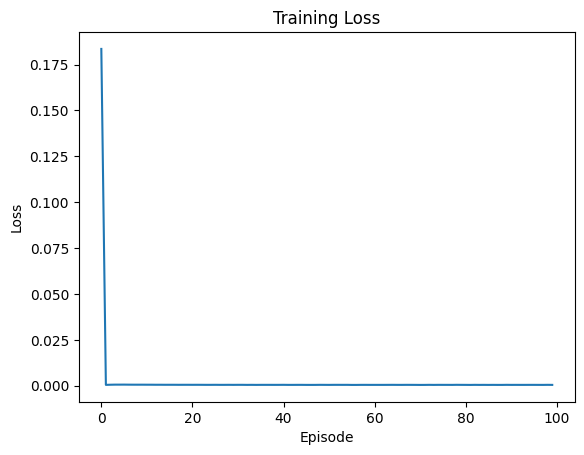

In [14]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()

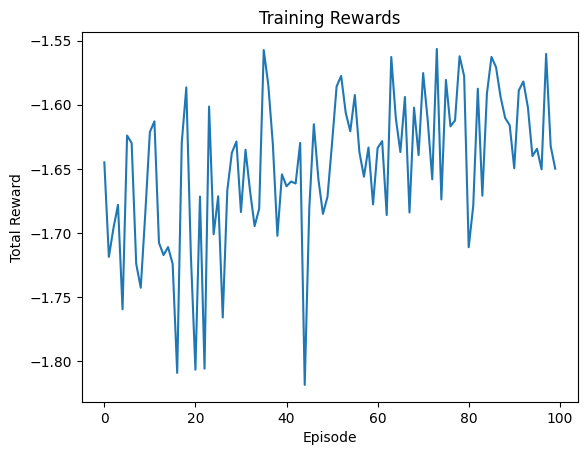

In [15]:
plt.plot(rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [16]:
def test_agent(env, agent, episodes=100):
    total_rewards = []
    decisions = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        episode_decisions = []

        while not done:
            lap_decision, tire_choice = agent.act(state, epsilon=0)
            next_state, reward, done, _ = env.step((lap_decision, tire_choice))
            state = next_state
            total_reward += reward
            
            # Record the decision if a pit stop is made
            if tire_choice != 0:  # 0 means 'no action' for tire choicesqq
                episode_decisions.append((lap_decision, tire_choice))

        total_rewards.append(total_reward)
        decisions.append(episode_decisions)
        print(f"Test Episode {episode + 1}: Total Reward = {total_reward}")

    average_reward = sum(total_rewards) / len(total_rewards)
    print(f"Average Reward over {episodes} episodes: {average_reward}")
    return average_reward, decisions

Test Episode 1: Total Reward = -1.6436405797563731
Test Episode 2: Total Reward = -1.6436405797563731
Test Episode 3: Total Reward = -1.6436405797563731
Test Episode 4: Total Reward = -1.6436405797563731
Test Episode 5: Total Reward = -1.6436405797563731
Test Episode 6: Total Reward = -1.6436405797563731
Test Episode 7: Total Reward = -1.6436405797563731
Test Episode 8: Total Reward = -1.6436405797563731
Test Episode 9: Total Reward = -1.6436405797563731
Test Episode 10: Total Reward = -1.6436405797563731
Test Episode 11: Total Reward = -1.6436405797563731
Test Episode 12: Total Reward = -1.6436405797563731
Test Episode 13: Total Reward = -1.6436405797563731
Test Episode 14: Total Reward = -1.6436405797563731
Test Episode 15: Total Reward = -1.6436405797563731
Test Episode 16: Total Reward = -1.6436405797563731
Test Episode 17: Total Reward = -1.6436405797563731
Test Episode 18: Total Reward = -1.6436405797563731
Test Episode 19: Total Reward = -1.6436405797563731
Test Episode 20: Tota

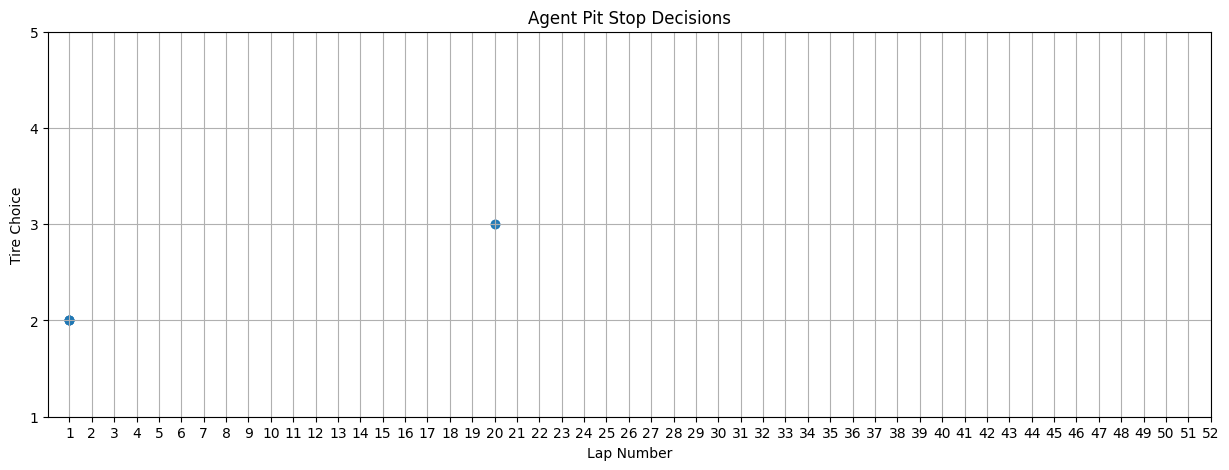

In [17]:
_, decisions = test_agent(env, agent, episodes=100)

all_decisions = [decision for episode in decisions for decision in episode]
laps, tire_choices = zip(*all_decisions)

plt.figure(figsize=(15, 5))
plt.scatter(laps, tire_choices, alpha=0.6)
plt.title('Agent Pit Stop Decisions')
plt.xlabel('Lap Number')
plt.ylabel('Tire Choice')
plt.xticks(np.arange(1, env.lap_count+1))
plt.yticks(np.arange(1, NUM_TYRES+1))
plt.grid(True)
plt.show()

In [18]:
TIRE_CHOICE_MAP = {1: 'Soft', 2: 'Medium', 3: 'Hard', 4: 'Intermediates', 5: 'Wets'}
tire_decisions = [TIRE_CHOICE_MAP[tire_choice] for tire_choice in tire_choices]
unique_decisions = list(set(zip(laps, tire_decisions)))
print(unique_decisions)

[(1, 'Medium'), (20, 'Hard')]
